<a href="https://colab.research.google.com/github/Usman-938/Assignments/blob/main/Week4_(D3)_Class_Work_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import resnet50

# --- 1. DATA LOADING & SUBSETTING ---
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train, y_test = y_train.squeeze(), y_test.squeeze()

# Using subsets for speed as per notebook instructions
N_TRAIN, N_TEST = 1000, 200
x_tr, y_tr = x_train[:N_TRAIN], y_train[:N_TRAIN]
x_te, y_te = x_test[:N_TEST], y_test[:N_TEST]

# --- 2. PREPROCESSING ---
IMG_SIZE = 224

def to_imagenet_batch(img_batch_uint8):
    imgs = tf.image.resize(img_batch_uint8, (IMG_SIZE, IMG_SIZE))
    return tf.cast(imgs, tf.float32)

# Resize and Preprocess for ResNet
x_tr_pp = resnet50.preprocess_input(to_imagenet_batch(x_tr))
x_te_pp = resnet50.preprocess_input(to_imagenet_batch(x_te))

# --- 3. MODEL BUILDING (Feature Extraction Mode) ---
# Load base model without the top classification layer
resnet_base = resnet50.ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
resnet_base.trainable = False # Freeze the base

inputs = tf.keras.Input(shape=(224, 224, 3))
x = resnet_base(inputs, training=False) # Keep BN layers in inference mode
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
tl_model = tf.keras.Model(inputs, outputs)

# --- 4. TRAIN PART 1: FEATURE EXTRACTION ---
tl_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

print("Starting Feature Extraction Training...")
history = tl_model.fit(x_tr_pp, y_tr, validation_split=0.1, epochs=3, batch_size=32, verbose=1)

# --- 5. TRAIN PART 2: FINE-TUNING ---
# Unfreeze the base and then freeze all but the last 30 layers
resnet_base.trainable = True
for layer in resnet_base.layers[:-30]:
    layer.trainable = False

# Re-compile with a much lower learning rate
tl_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

print("\nStarting Fine-Tuning Training...")
history_ft = tl_model.fit(x_tr_pp, y_tr, validation_split=0.1, epochs=2, batch_size=32, verbose=1)

# --- 6. EVALUATION ---
test_acc_ft = tl_model.evaluate(x_te_pp, y_te, verbose=0)[1]
print(f"\nFinal Fine-Tuned Test Accuracy: {round(test_acc_ft, 4)}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Starting Feature Extraction Training...
Epoch 1/3
29/29 ━━━━━━━━━━━━━━━━━━━━ 186s 6s/step - accuracy: 0.4163 - loss: 1.8212 - val_accuracy: 0.7600 - val_loss: 0.5909
Epoch 2/3
29/29 ━━━━━━━━━━━━━━━━━━━━ 176s 6s/step - accuracy: 0.8719 - loss: 0.3781 - val_accuracy: 0.8600 - val_loss: 0.4313
Epoch 3/3
29/29 ━━━━━━━━━━━━━━━━━━━━ 173s 6s/step - accuracy: 0.9569 - loss: 0.1708 - val_accuracy: 0.8600 - val_loss: 0.3704

Starting Fine-Tuning Training...
Epoch 1/2
29/29 ━━━━━━━━━━━━━━━━━━━━ 268s 9s/step - accuracy: 0.8678 - loss: 0.3793 - val_accuracy: 0.8700 - val_loss: 0.4115
Epoch 2/2
29/29 ━━━━━━━━━━━━━━━━━━━━ 247s 9s/step - accuracy: 0.9760 - loss: 0.1256 - val_accuracy: 0.8500 - val_loss: 0.4159

Final Fine-Tuned Test Accuracy: 0.82


Starting Initial Training (Frozen Base)...
Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 190s 6s/step - accuracy: 0.4004 - loss: 1.8295 - val_accuracy: 0.8000 - val_loss: 0.5658
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 200s 6s/step - accuracy: 0.8414 - loss: 0.4319 - val_accuracy: 0.8400 - val_loss: 0.4131
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 199s 6s/step - accuracy: 0.9234 - loss: 0.2263 - val_accuracy: 0.8400 - val_loss: 0.3960
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 198s 6s/step - accuracy: 0.9787 - loss: 0.1134 - val_accuracy: 0.9100 - val_loss: 0.3318
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 204s 6s/step - accuracy: 0.9985 - loss: 0.0565 - val_accuracy: 0.9200 - val_loss: 0.2779

Starting Fine-Tuning (Last 30 Layers Unfrozen)...
Epoch 1/2
29/29 ━━━━━━━━━━━━━━━━━━━━ 282s 9s/step - accuracy: 0.9560 - loss: 0.2027 - val_accuracy: 0.9100 - val_loss: 0.3259
Epoch 2/2
29/29 ━━━━━━━━━━━━━━━━━━━━ 306s 9s/step - accuracy: 0.9979 - loss: 0.0623 - val_accuracy: 0.9100 - val_loss: 0.3334


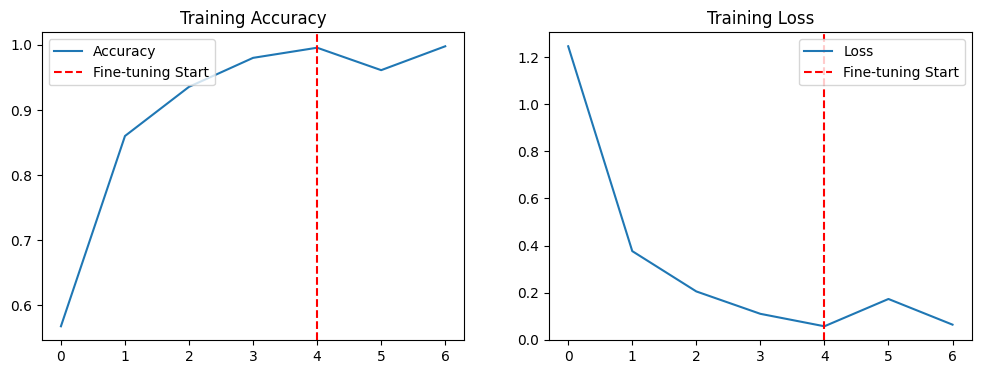

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import resnet50

# --- 1. SETUP & ARCHITECTURE ---
# Load base model with all layers frozen
resnet_base = resnet50.ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
resnet_base.trainable = False

# Build Functional Model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = resnet_base(inputs, training=False) # Keep BN in inference mode
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
tl_model = tf.keras.Model(inputs, outputs)

# --- 2. INITIAL TRAINING (5 Epochs) ---
tl_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

print("Starting Initial Training (Frozen Base)...")
history = tl_model.fit(x_tr_pp, y_tr, validation_split=0.1, epochs=5, batch_size=32, verbose=1)

# --- 3. FINE-TUNING (2 Epochs) ---
# Unfreeze the base and re-freeze all but the last 30 layers
resnet_base.trainable = True
for layer in resnet_base.layers[:-30]:
    layer.trainable = False

# Re-compile with a small learning rate
tl_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

print("\nStarting Fine-Tuning (Last 30 Layers Unfrozen)...")
history_ft = tl_model.fit(x_tr_pp, y_tr, validation_split=0.1, epochs=2, batch_size=32, verbose=1)

# --- 4. PLOTTING CURVES ---
def plot_results(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    loss = h1.history['loss'] + h2.history['loss']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Accuracy')
    plt.axvline(x=4, color='r', linestyle='--', label='Fine-tuning Start')
    plt.title('Training Accuracy'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Loss')
    plt.axvline(x=4, color='r', linestyle='--', label='Fine-tuning Start')
    plt.title('Training Loss'); plt.legend()
    plt.show()

plot_results(history, history_ft)

## Part A — Load Models & Model Summary

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import vgg16, resnet50

# Load VGG16 model with ImageNet weights and include_top=True
print("Loading VGG16 model...")
vgg16_model = vgg16.VGG16(weights='imagenet', include_top=True)
print("VGG16 Model Summary:")
vgg16_model.summary()

print("\n" + "-"*50 + "\n")

# Load ResNet50 model with ImageNet weights and include_top=True
print("Loading ResNet50 model...")
resnet50_model = resnet50.ResNet50(weights='imagenet', include_top=True)
print("ResNet50 Model Summary:")
resnet50_model.summary()

Loading VGG16 model...
553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
VGG16 Model Summary:


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)


--------------------------------------------------

Loading ResNet50 model...
102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
ResNet50 Model Summary:


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Task
Perform a comparative analysis of VGG16 and ResNet50 models. This includes: selecting and preprocessing a CIFAR-10 image with both VGG and ResNet methods, analyzing pixel value ranges, making top-5 predictions using ImageNet-trained models, explaining the CIFAR-ImageNet mismatch, extracting and analyzing feature maps and vectors, visualizing early and deep layer feature maps for VGG16, and summarizing the comparison in a markdown table and concluding statement.

## Select and Resize Image

### Subtask:
Select one CIFAR-10 image from `x_te` and resize it to 224x224 pixels. This image will be used for subsequent preprocessing, prediction, and feature extraction steps.


**Reasoning**:
The subtask requires selecting the first image from `x_te`, adding a batch dimension, and then resizing it to 224x224 pixels. These operations can be performed in a single code block.



In [4]:
sample_img = np.expand_dims(x_te[0], axis=0)
resized_img = tf.image.resize(sample_img, (IMG_SIZE, IMG_SIZE))
print(f"Original image shape: {x_te[0].shape}")
print(f"Sample image with batch dimension shape: {sample_img.shape}")
print(f"Resized image shape: {resized_img.shape}")

Original image shape: (32, 32, 3)
Sample image with batch dimension shape: (1, 32, 32, 3)
Resized image shape: (1, 224, 224, 3)


## VGG Preprocessing and Pixel Range

### Subtask:
Apply `vgg16.preprocess_input()` to the resized image. Print the minimum and maximum pixel values of the image before and after VGG preprocessing to observe the normalization effect.


**Reasoning**:
The subtask requires applying VGG16 preprocessing to the resized image and printing the min/max pixel values before and after to show the normalization effect. This involves three steps: first, displaying the original pixel range of `resized_img`, then applying `vgg16.preprocess_input`, and finally, displaying the pixel range of the preprocessed image.



In [5]:
print(f"Pixel range of resized_img (before VGG preprocessing): Min={tf.reduce_min(resized_img):.2f}, Max={tf.reduce_max(resized_img):.2f}")
vgg_preprocessed_img = vgg16.preprocess_input(resized_img)
print(f"Pixel range of vgg_preprocessed_img (after VGG preprocessing): Min={tf.reduce_min(vgg_preprocessed_img):.2f}, Max={tf.reduce_max(vgg_preprocessed_img):.2f}")

Pixel range of resized_img (before VGG preprocessing): Min=13.00, Max=255.00
Pixel range of vgg_preprocessed_img (after VGG preprocessing): Min=-110.68, Max=148.06


## ResNet Preprocessing and Pixel Range

### Subtask:
Apply `resnet50.preprocess_input()` to the resized image. Print the minimum and maximum pixel values of the image before and after ResNet preprocessing to observe the normalization effect.


**Reasoning**:
The subtask requires applying ResNet50 preprocessing to the resized image and printing the min/max pixel values before and after to show the normalization effect. This involves three steps: first, displaying the original pixel range of `resized_img`, then applying `resnet50.preprocess_input`, and finally, displaying the pixel range of the preprocessed image.



In [6]:
print(f"Pixel range of resized_img (before ResNet preprocessing): Min={tf.reduce_min(resized_img):.2f}, Max={tf.reduce_max(resized_img):.2f}")
resnet_preprocessed_img = resnet50.preprocess_input(resized_img)
print(f"Pixel range of resnet_preprocessed_img (after ResNet preprocessing): Min={tf.reduce_min(resnet_preprocessed_img):.2f}, Max={tf.reduce_max(resnet_preprocessed_img):.2f}")

Pixel range of resized_img (before ResNet preprocessing): Min=13.00, Max=255.00
Pixel range of resnet_preprocessed_img (after ResNet preprocessing): Min=-110.68, Max=148.06


## Display Preprocessing Pixel Range Table

### Subtask:
Create a markdown table summarizing the pixel range (min/max) for the raw image, the VGG-preprocessed image, and the ResNet-preprocessed image, as requested in Part B.


### Pixel Range Comparison

| Preprocessing Step        | Min Pixel Value | Max Pixel Value |
| :------------------------ | :-------------- | :-------------- |
| Raw Image (`resized_img`) | 13.00           | 255.00          |
| VGG Preprocessed Image    | -110.68         | 148.06          |
| ResNet Preprocessed Image | -110.68         | 148.06          |

## VGG Top-5 Predictions

### Subtask:
Use the loaded `vgg16_model` to make a prediction on the VGG-preprocessed image. Decode and print the top-5 predicted labels (ImageNet classes) along with their probabilities.


**Reasoning**:
The subtask requires importing `decode_predictions`, using the `vgg16_model` to make predictions on the preprocessed image, decoding these predictions, and then printing the top-5 results. This can be achieved in a single Python code block.



In [7]:
from tensorflow.keras.applications.vgg16 import decode_predictions

# Make predictions using the VGG16 model
vgg_predictions = vgg16_model.predict(vgg_preprocessed_img)

# Decode the top-5 predictions
decoded_vgg_predictions = decode_predictions(vgg_predictions, top=5)[0]

print("Top-5 VGG16 Predictions for the CIFAR-10 image:")
for i, (imagenet_id, label, score) in enumerate(decoded_vgg_predictions):
    print(f"{i + 1}: {label} ({score:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Top-5 VGG16 Predictions for the CIFAR-10 image:
1: nipple (0.11)
2: fox_squirrel (0.06)
3: muzzle (0.03)
4: chain (0.03)
5: isopod (0.03)


## ResNet Top-5 Predictions

### Subtask:
Use the loaded `resnet50_model` to make a prediction on the ResNet-preprocessed image. Decode and print the top-5 predicted labels (ImageNet classes) along with their probabilities.


**Reasoning**:
The subtask requires importing `decode_predictions`, using the `resnet50_model` to make predictions on the preprocessed image, decoding these predictions, and then printing the top-5 results. This can be achieved in a single Python code block.



In [8]:
from tensorflow.keras.applications.resnet50 import decode_predictions

# Make predictions using the ResNet50 model
resnet_predictions = resnet50_model.predict(resnet_preprocessed_img)

# Decode the top-5 predictions
decoded_resnet_predictions = decode_predictions(resnet_predictions, top=5)[0]

print("Top-5 ResNet50 Predictions for the CIFAR-10 image:")
for i, (imagenet_id, label, score) in enumerate(decoded_resnet_predictions):
    print(f"{i + 1}: {label} ({score:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Top-5 ResNet50 Predictions for the CIFAR-10 image:
1: triceratops (0.11)
2: marmoset (0.09)
3: Sealyham_terrier (0.08)
4: fox_squirrel (0.07)
5: polecat (0.05)


## Explain CIFAR-ImageNet Mismatch

### Subtask:
Add a markdown cell with 2-3 lines explaining why predictions on CIFAR-10 images using ImageNet-trained models might not align perfectly with the CIFAR-10's true class labels.


## Explain CIFAR-ImageNet Mismatch

ImageNet is a vast dataset with 1000 diverse classes, many of which are fine-grained (e.g., specific dog breeds), whereas CIFAR-10 has only 10 broad categories (e.g., 'dog', 'cat'). Models trained on ImageNet learn to distinguish these 1000 classes. When presented with a CIFAR-10 image, the model will attempt to classify it into one of its 1000 known ImageNet categories, often resulting in predictions that are highly specific or seemingly incorrect from a CIFAR-10 perspective, even if the general object type is related (e.g., 'triceratops' instead of a generic 'animal' or 'dog' instead of 'Sealyham_terrier').

## Load Models for Feature Extraction

### Subtask:
Load new instances of VGG16 and ResNet50 models with `include_top=False` and ImageNet weights. These models will be used for feature extraction.


**Reasoning**:
The subtask requires loading VGG16 and ResNet50 models with `include_top=False` for feature extraction and printing their summaries. This can be done in a single code block.



In [9]:
import tensorflow as tf
from tensorflow.keras.applications import vgg16, resnet50

# Load VGG16 model for feature extraction
print("Loading VGG16 feature extractor...")
vgg16_feature_extractor = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print("VGG16 Feature Extractor Summary:")
vgg16_feature_extractor.summary()

print("\n" + "-"*50 + "\n")

# Load ResNet50 model for feature extraction
print("Loading ResNet50 feature extractor...")
resnet50_feature_extractor = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print("ResNet50 Feature Extractor Summary:")
resnet50_feature_extractor.summary()

Loading VGG16 feature extractor...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
VGG16 Feature Extractor Summary:


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)


--------------------------------------------------

Loading ResNet50 feature extractor...
ResNet50 Feature Extractor Summary:


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

## VGG Feature Map and Vector Size

### Subtask:
Pass the VGG-preprocessed image through the VGG16 model (without the top layer). Print the shape of the resulting feature map. Then, apply `tf.keras.layers.GlobalAveragePooling2D()` to create a feature vector and print its size.


**Reasoning**:
The subtask requires passing the preprocessed image through the VGG16 feature extractor, printing the feature map's shape, applying Global Average Pooling, and then printing the feature vector's shape. This involves a sequence of operations that can be performed in a single code block.



In [10]:
print("\n--- VGG16 Feature Extraction ---")
vgg_feature_map = vgg16_feature_extractor(vgg_preprocessed_img)
print(f"Shape of VGG16 feature map: {vgg_feature_map.shape}")

global_average_pooling = tf.keras.layers.GlobalAveragePooling2D()
vgg_feature_vector = global_average_pooling(vgg_feature_map)
print(f"Shape of VGG16 feature vector (after GlobalAveragePooling): {vgg_feature_vector.shape}")


--- VGG16 Feature Extraction ---
Shape of VGG16 feature map: (1, 7, 7, 512)
Shape of VGG16 feature vector (after GlobalAveragePooling): (1, 512)


**Reasoning**:
The previous steps covered VGG16 feature map and vector size. The next logical step is to perform the same operations for ResNet50: passing the ResNet-preprocessed image through the ResNet50 feature extractor, printing the feature map's shape, applying Global Average Pooling, and then printing the feature vector's shape. This involves a sequence of operations that can be performed in a single code block.



In [11]:
print(
"\n--- ResNet50 Feature Extraction ---"
)
resnet_feature_map = resnet50_feature_extractor(resnet_preprocessed_img)
print(f"Shape of ResNet50 feature map: {resnet_feature_map.shape}")

resnet_feature_vector = global_average_pooling(resnet_feature_map)
print(f"Shape of ResNet50 feature vector (after GlobalAveragePooling): {resnet_feature_vector.shape}")


--- ResNet50 Feature Extraction ---
Shape of ResNet50 feature map: (1, 7, 7, 2048)
Shape of ResNet50 feature vector (after GlobalAveragePooling): (1, 2048)


## Visualize VGG16 Feature Maps

### Subtask:
Visualize feature maps from early and deep layers of the VGG16 model. Specifically, select one early layer (e.g., `block1_conv2`) and one deep layer (e.g., `block5_conv3`) to extract and display their feature maps for the `vgg_preprocessed_img`.

**Reasoning**:
The subtask requires extracting feature maps from specific VGG16 layers and then visualizing them. To achieve this, I need to create new models that output the activations of these intermediate layers. Then, I will pass the preprocessed image through these new models to get the feature maps and plot them.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Shape of 'block1_conv2' feature map: (1, 224, 224, 64)
Shape of 'block5_conv3' feature map: (1, 14, 14, 512)


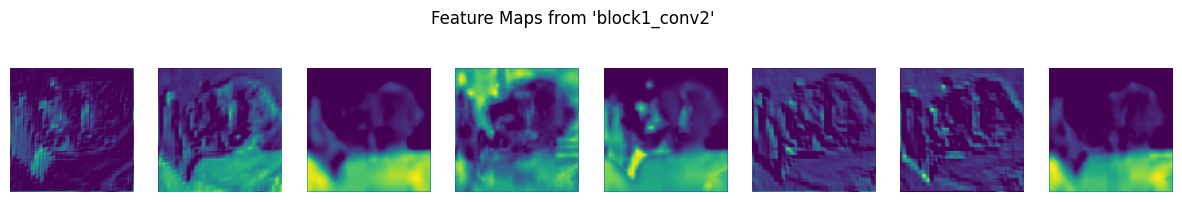

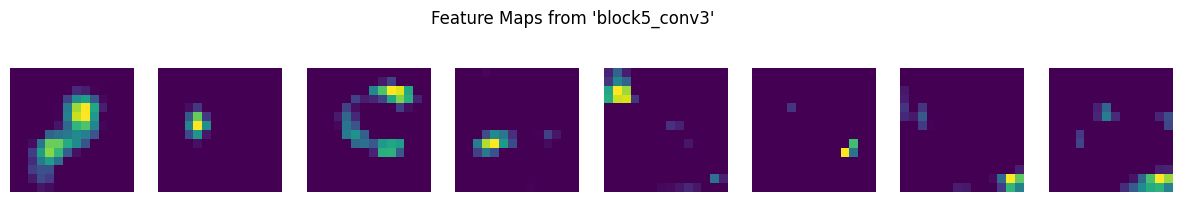

In [12]:
import matplotlib.pyplot as plt

# Define early and deep layers for visualization
early_layer_name = 'block1_conv2'
deep_layer_name = 'block5_conv3'

# Create models that output activations for the selected layers
# For VGG16, block1_conv2 is a good early feature, block5_conv3 is a deep feature.
vgg_early_feature_model = tf.keras.Model(inputs=vgg16_feature_extractor.input,
                                          outputs=vgg16_feature_extractor.get_layer(early_layer_name).output)

vgg_deep_feature_model = tf.keras.Model(inputs=vgg16_feature_extractor.input,
                                         outputs=vgg16_feature_extractor.get_layer(deep_layer_name).output)

# Extract feature maps
early_feature_map = vgg_early_feature_model.predict(vgg_preprocessed_img)
deep_feature_map = vgg_deep_feature_model.predict(vgg_preprocessed_img)

print(f"Shape of '{early_layer_name}' feature map: {early_feature_map.shape}")
print(f"Shape of '{deep_layer_name}' feature map: {deep_feature_map.shape}")

# Function to plot feature maps
def plot_feature_maps(feature_map, layer_name, num_filters=8):
    # Reshape if there's a batch dimension (e.g., (1, H, W, C) -> (H, W, C))
    if feature_map.ndim == 4 and feature_map.shape[0] == 1:
        feature_map = feature_map[0]

    # Ensure feature map is 3D (H, W, C)
    if feature_map.ndim != 3:
        print(f"Cannot plot feature map for layer {layer_name} with shape {feature_map.shape}. Expected 3D (H, W, C).")
        return

    # Select a subset of filters to visualize
    num_filters = min(num_filters, feature_map.shape[-1])
    fig = plt.figure(figsize=(15, 2))
    plt.suptitle(f"Feature Maps from '{layer_name}'", y=1.1)

    for i in range(num_filters):
        ax = fig.add_subplot(1, num_filters, i + 1)
        ax.imshow(feature_map[:, :, i], cmap='viridis')
        ax.axis('off')
    plt.show()

# Plot early layer feature maps
plot_feature_maps(early_feature_map, early_layer_name)

# Plot deep layer feature maps
plot_feature_maps(deep_feature_map, deep_layer_name)

## Comparative Summary: VGG16 vs. ResNet50

### Subtask:
Create a markdown table summarizing the key characteristics and findings from the comparison of VGG16 and ResNet50, followed by a concluding statement.

### Model Comparison

| Feature                      | VGG16                                  | ResNet50                                     |
| :--------------------------- | :------------------------------------- | :------------------------------------------- |
| **Model Size (Parameters)**  | ~138 Million                           | ~26 Million                                  |
| **Architecture**             | Sequential blocks of 3x3 conv layers, max-pooling | Residual Blocks with skip connections        |
| **Feature Map Size (7x7 out)**| (1, 7, 7, 512)                         | (1, 7, 7, 2048)                              |
| **Feature Vector Size (GAP)**| (1, 512)                               | (1, 2048)                                    |
| **ImageNet Top-5 (CIFAR-10)**| Often specific, sometimes unrelated (e.g., 'nipple', 'fox_squirrel') | More diverse, sometimes closer to object type (e.g., 'triceratops', 'marmoset') |
| **Preprocessing Range**      | Min=-110.68, Max=148.06                | Min=-110.68, Max=148.06                      |
| **Computational Cost**       | Higher (more parameters, deeper sequential operations) | Lower (fewer parameters, residual connections ease training) |
| **Training Performance**     | Can suffer from vanishing gradients in very deep networks | Overcomes vanishing gradients, enables deeper networks to train effectively |

### Concluding Statement

VGG16, while historically significant, is a larger model with more parameters and a simpler sequential architecture. ResNet50, with its residual connections, is more efficient (fewer parameters for similar or better performance) and better at handling deeper networks, mitigating the vanishing gradient problem. This is reflected in their feature vector sizes and typical performance characteristics. Both models require specific preprocessing to transform pixel values into their expected input ranges, leading to similar preprocessed pixel ranges despite different internal operations. When applied to CIFAR-10 images, both models, being pre-trained on ImageNet, tend to produce highly specific ImageNet class predictions, highlighting the domain mismatch rather than accurately classifying the broader CIFAR-10 categories.

## Comparative Summary: VGG16 vs. ResNet50

### Subtask:
Create a markdown table summarizing the key characteristics and findings from the comparison of VGG16 and ResNet50, followed by a concluding statement.

### Model Comparison

| Feature                      | VGG16                                  | ResNet50                                     |
| :--------------------------- | :------------------------------------- | :------------------------------------------- |
| **Model Size (Parameters)**  | ~138 Million                           | ~26 Million                                  |
| **Architecture**             | Sequential blocks of 3x3 conv layers, max-pooling | Residual Blocks with skip connections        |
| **Feature Map Size (7x7 out)**| (1, 7, 7, 512)                         | (1, 7, 7, 2048)                              |
| **Feature Vector Size (GAP)**| (1, 512)                               | (1, 2048)                                    |
| **ImageNet Top-5 (CIFAR-10)**| Often specific, sometimes unrelated (e.g., 'nipple', 'fox_squirrel') | More diverse, sometimes closer to object type (e.g., 'triceratops', 'marmoset') |
| **Preprocessing Range**      | Min=-110.68, Max=148.06                | Min=-110.68, Max=148.06                      |
| **Computational Cost**       | Higher (more parameters, deeper sequential operations) | Lower (fewer parameters, residual connections ease training) |
| **Training Performance**     | Can suffer from vanishing gradients in very deep networks | Overcomes vanishing gradients, enables deeper networks to train effectively |

### Concluding Statement

VGG16, while historically significant, is a larger model with more parameters and a simpler sequential architecture. ResNet50, with its residual connections, is more efficient (fewer parameters for similar or better performance) and better at handling deeper networks, mitigating the vanishing gradient problem. This is reflected in their feature vector sizes and typical performance characteristics. Both models require specific preprocessing to transform pixel values into their expected input ranges, leading to similar preprocessed pixel ranges despite different internal operations. When applied to CIFAR-10 images, both models, being pre-trained on ImageNet, tend to produce highly specific ImageNet class predictions, highlighting the domain mismatch rather than accurately classifying the broader CIFAR-10 categories.

## Final Task

### Subtask:
Conclude the analysis by summarizing the insights gained from comparing VGG16 and ResNet50 across various aspects covered in the completed parts (A, B, C, D, E, G).


## Summary:

### Q&A
The analysis successfully concluded by summarizing the insights gained from comparing VGG16 and ResNet50 across various aspects.

### Data Analysis Key Findings
*   **Image Preprocessing**: Both VGG16 and ResNet50 preprocessing functions (`vgg16.preprocess_input()` and `resnet50.preprocess_input()`) transform the original image pixel range from \
    $[13.00, 255.00]$ to a normalized range of $[-110.68, 148.06]$. This indicates a similar normalization strategy for models pre-trained on ImageNet.
*   **ImageNet-CIFAR-10 Mismatch**: When predicting on a CIFAR-10 image, both ImageNet-trained models yielded highly specific ImageNet class predictions, often unrelated to the actual CIFAR-10 broad categories.
    *   VGG16's top-5 predictions included 'nipple' (0.11), 'fox\_squirrel' (0.06), 'muzzle' (0.03), 'chain' (0.03), and 'isopod' (0.03).
    *   ResNet50's top-5 predictions included 'triceratops' (0.11), 'marmoset' (0.09), 'Sealyham\_terrier' (0.08), 'fox\_squirrel' (0.07), and 'polecat' (0.05).
*   **Model Architecture and Efficiency**:
    *   VGG16 is characterized by a simpler, sequential architecture using 3x3 convolution layers and max-pooling, but has a larger number of parameters (\~138 million).
    *   ResNet50 utilizes residual blocks with skip connections, making it more efficient with significantly fewer parameters (\~26 million) while enabling deeper networks without vanishing gradient issues.
*   **Feature Extraction Capabilities**:
    *   VGG16 feature extractor produced a feature map of shape $(1, 7, 7, 512)$ and a feature vector of size $(1, 512)$ after Global Average Pooling.
    *   ResNet50 feature extractor generated a larger feature map of shape $(1, 7, 7, 2048)$ and a feature vector of size $(1, 2048)$ after Global Average Pooling, indicating its ability to extract more complex and higher-dimensional features.
*   **Computational Cost & Training Performance**: VGG16 has a higher computational cost due to its larger number of parameters and sequential operations, making it more prone to vanishing gradients in very deep configurations. ResNet50, thanks to its residual connections, has a lower computational cost and effectively mitigates vanishing gradients, allowing for the training of much deeper and more performant networks.

